In [1]:
import re
import warnings
import numpy as np
import pandas as pd
import scipy
import sklearn
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from statannot import add_stat_annotation

from utils import quick_load_liuzhong_health_check_data, parse_dict_with_default
from plot_utils import Stack, Scatter, Sankey, BxxPvalue

%matplotlib inline
%load_ext autoreload
%autoreload 2

import rpy2.robjects as ro
from rpy2.robjects import r, pandas2ri
import rpy2.robjects.lib.ggplot2 as ggplot2
%load_ext rpy2.ipython

warnings.filterwarnings("ignore")

df_table1plus, l_consecute_man2p, l_consecute_man3p, df_table1plus_3p_revMM, df_meta_group, rename_dict = quick_load_liuzhong_health_check_data()
workdir = "/cluster/home/bqhu_jh/projects/healthman/analysis/liuzhong/human/clinical/figures"

In [2]:
%%R
pkgs <- c("fs", "configr", "stringr", "jhtools", "glue", "tidyverse", "dplyr", 
          "readr", "jhdata", "ggplot2", "ggpubr", "patchwork")
for (pkg in pkgs){
  suppressPackageStartupMessages(library(pkg, character.only = T))
}



project <- "healthman"
species <- "human"
dataset <- "liuzhong"

workdir <- glue("~/projects/{project}/analysis/")
setwd(workdir)

## People number

In [3]:
# left, year number
p1_df = df_table1plus[["period", "gender"]].\
            pivot_table(index="period", values="gender", aggfunc=len).\
            reset_index()

# middle, year-gender number
p2_df_a = df_table1plus[["period", "gender"]].\
            pivot_table(index=["period", "gender"], aggfunc=len).\
            reset_index()
p2_df_a.columns = ["period", "gender", "number"]
p2_df_c = df_table1plus_3p_revMM[["period", "gender", "sample_id"]].\
            pivot_table(index=["period", "gender"], values="sample_id", aggfunc=lambda x: len(set(x))).\
            reset_index()
p2_df_c.columns = ["period", "gender", "number"]
p2_df_c = p2_df_c.iloc[0:2]
p2_df_c["period"] = "3 periods"

p2_df = pd.concat([p2_df_a, p2_df_c])

col_used = ["period", "gender", "age"]

p3_age_df = df_table1plus[col_used]
p3_age_df

p4_age_df = df_table1plus_3p_revMM[col_used]
p4_age_df

variable,period,gender,age
0,Control-2021,female,28
1,Control-2022,female,29
2,Test-2023,female,30
3,Control-2021,female,24
4,Control-2022,female,25
...,...,...,...
63796,Control-2022,male,38
63797,Test-2023,male,39
63798,Control-2021,male,51
63799,Control-2022,male,52


In [4]:
print(p3_age_df["age"].mean())
print(p3_age_df.groupby([ "gender"]).agg(np.nanmean))
p3_age_df.groupby(["period", "gender"]).agg(np.nanmean)

43.14370083719048
              age
gender           
female  41.431277
male    44.840946


age
period       gender           
Control-2021 female  41.178626
             male    44.936100
Control-2022 female  41.147454
             male    44.562665
Test-2023    female  41.935153
             male    45.004617

In [5]:
print(p4_age_df["age"].mean())
print(p4_age_df[p4_age_df["period"]=="Test-2023"]["age"].mean())
print(p4_age_df.groupby([ "gender"]).agg(np.nanmean))
p4_age_df.groupby(["period", "gender"]).agg(np.nanmean)

44.327110860331345
45.32736164009968
variable        age
gender             
female    42.220675
male      46.904164


variable                   age
period       gender           
Control-2021 female  41.220561
             male    45.903293
Control-2022 female  42.220731
             male    46.904548
Test-2023    female  43.220731
             male    47.904652

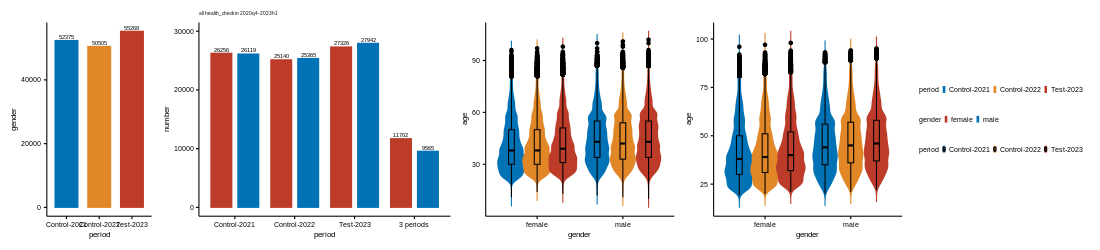

In [6]:
%%R -i p1_df -i p2_df -i p3_age_df -i p4_age_df -w 1100 -h 250 -u px

cols_gender <- ggsci::pal_nejm("default")(2)
colrs_year <- c("Control-2021" = "#0172B6",  "Control-2022" = "#E18727", "Test-2023" = "#BD3C29")
p1_df$period <- factor(p1_df$period, levels=c("Control-2021",  "Control-2022", "Test-2023"))
p2_df$period <- factor(p2_df$period, levels=c("Control-2021",  "Control-2022", "Test-2023", "3 periods"))
p3_age_df$period <- factor(p3_age_df$period, levels=c("Control-2021",  "Control-2022", "Test-2023"))
p4_age_df$period <- factor(p4_age_df$period, levels=c("Control-2021",  "Control-2022", "Test-2023"))

p2_df$gender <- factor(p2_df$gender, levels=c("female",  "male"))
p3_age_df$gender <- factor(p3_age_df$gender, levels=c("female",  "male"))
p4_age_df$gender <- factor(p4_age_df$gender, levels=c("female",  "male"))


p1 <- ggbarplot(p1_df, "period", "gender",
                fill = "period",  color = "period",
                palette = colrs_year, label = TRUE,
                lab.size = 2,
                position = position_dodge(0.9)) +
    theme(title = element_text(size = 4),
          axis.title.y = element_text(size = 8),
          axis.text.y = element_text(size = 7),
          axis.title.x = element_text(size = 8),
          axis.text.x = element_text(size = 7),
          legend.text = element_text(size = 7),
          legend.title = element_text(size = 7),
          legend.key.size = unit(0.1, 'cm'))

p2 <- ggbarplot(p2_df, "period", "number",
                fill = "gender",  color = "gender",
                palette = cols_gender, label = TRUE,
                lab.size = 2,
                position = position_dodge(0.9)) +
    ylim(0, 30000) +
    ggtitle("all health_check in 2020q4-2023h1") +
    theme(title = element_text(size = 4),
          axis.title.y = element_text(size = 8),
          axis.text.y = element_text(size = 7),
          axis.title.x = element_text(size = 8),
          axis.text.x = element_text(size = 7),
          legend.text = element_text(size = 7),
          legend.title = element_text(size = 7),
          legend.key.size = unit(0.1, 'cm'))

p3 <- ggviolin(p3_age_df, "gender", "age",
                fill = "period", 
                color = "period",
                palette = colrs_year,
                add = "boxplot", 
                add.params = list(color="black"),
                position = position_dodge(0.9)
    ) +
    theme(title = element_text(size = 4),
        axis.title.y = element_text(size = 8),
        axis.text.y = element_text(size = 7),
        axis.title.x = element_text(size = 8),
        axis.text.x = element_text(size = 7),
        legend.text = element_text(size = 7),
        legend.title = element_text(size = 7),
        legend.key.size = unit(0.1, 'cm'))

p4 <- ggviolin(p4_age_df, "gender", "age",
                fill = "period", 
                color = "period",
                palette = colrs_year,
                add = "boxplot", 
                add.params = list(color="black"),
                position = position_dodge(0.9)
    ) +
    theme(title = element_text(size = 4),
        axis.title.y = element_text(size = 8),
        axis.text.y = element_text(size = 7),
        axis.title.x = element_text(size = 8),
        axis.text.x = element_text(size = 7),
        legend.text = element_text(size = 7),
        legend.title = element_text(size = 7),
        legend.key.size = unit(0.1, 'cm'))

pc <- (p1|p2|p3|p4) +
  plot_layout(guides = 'collect', widths = c(0.5, 1.2, 0.9, 0.9))
ggsave(glue("~/projects/{project}/analysis/liuzhong/{species}/clinical/figures/Figure1_ABC.pdf"), pc, 
           width = 11, height = 2.5)
pc

## people number by month

In [7]:
col_used = ["period", "month", "gender", "sample_id"]
# p1
p1_df = df_table1plus[col_used].\
    pivot_table(index=col_used[:-1], values="sample_id", aggfunc=lambda x: len(set(x))).\
    reset_index()
p1_df.columns = col_used[:-1] + ["number"]


df_common_2p = df_table1plus[df_table1plus["sample_id"].isin(l_consecute_man2p)]
df_common = df_table1plus[df_table1plus["sample_id"].isin(l_consecute_man3p)]

# p2
p2_p2_df = df_common_2p[col_used].\
    pivot_table(index=col_used[:-1], values="sample_id", aggfunc=lambda x: len(set(x))).\
    reset_index()
p2_p2_df.columns = col_used[:-1] + ["number"]
p2_p3_df = df_common[col_used].\
    pivot_table(index=col_used[:-1], values="sample_id", aggfunc=lambda x: len(set(x))).\
    reset_index()
p2_p3_df.columns = col_used[:-1] + ["number"]

# p3
p3_age_df = df_table1plus[col_used+["age"]].\
    pivot_table(index=col_used[:-1], values="age", aggfunc=np.nanmean).\
    reset_index()

# p4
p4_p2age_df = df_common_2p[col_used+["age"]].\
    pivot_table(index=col_used[:-1], values="age", aggfunc=np.nanmean).\
    reset_index()
p4_p3age_df = df_common[col_used+["age"]].\
    pivot_table(index=col_used[:-1], values="age", aggfunc=np.nanmean).\
    reset_index()

p2_p2_df = p2_p2_df[p2_p2_df["month"].isin([11,12,1,2,3, 4,5,6])]
p4_p2age_df = p4_p2age_df[p4_p2age_df["month"].isin([11,12,1,2,3, 4,5,6])]
p2_p3_df = p2_p3_df[p2_p3_df["month"].isin([11,12,1,2,3, 4,5,6])]
p4_p3age_df = p4_p3age_df[p4_p3age_df["month"].isin([11,12,1,2,3, 4,5,6])]

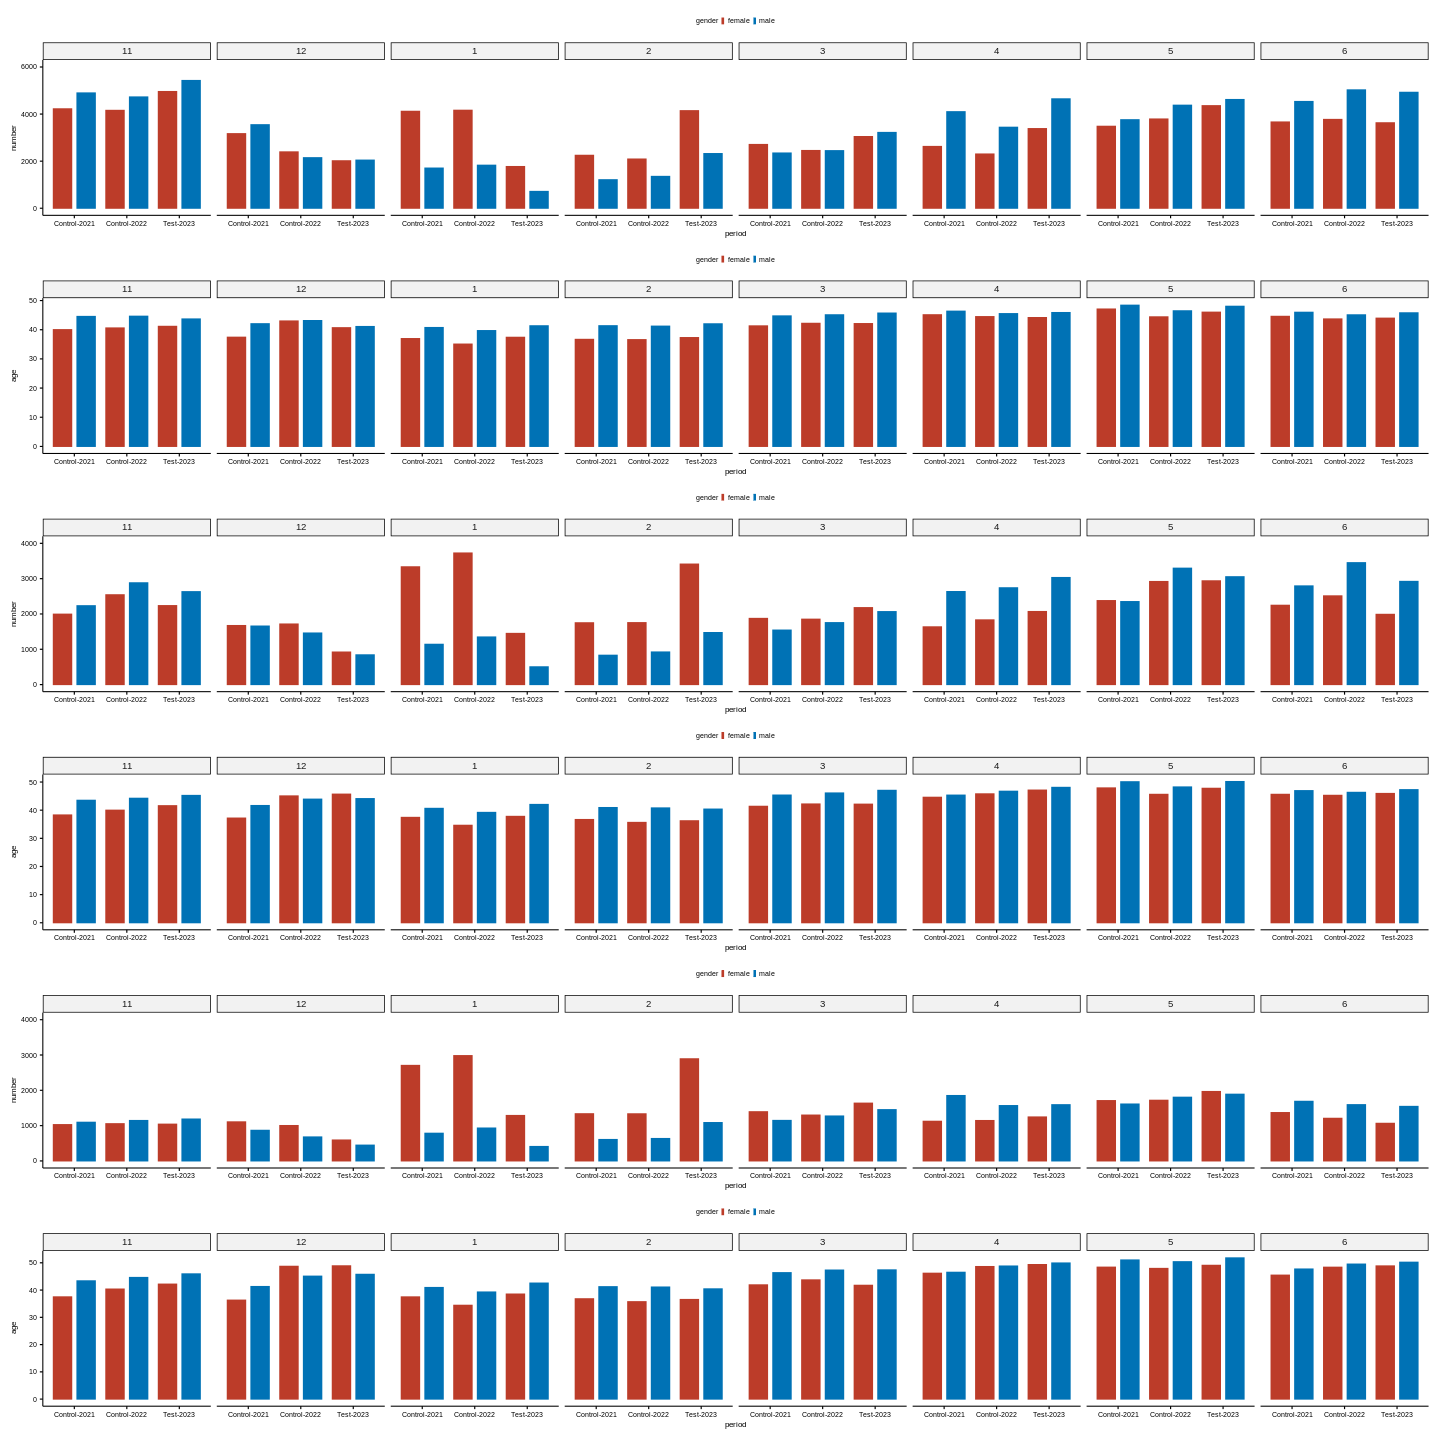

In [8]:
%%R -i p1_df -i p2_p2_df -i p2_p3_df -i p3_age_df -i p4_p3age_df -i p4_p2age_df -w 1440 -h 1440 -u px

cols_gender <- ggsci::pal_nejm("default")(2)
# colrs_year <- c("2021" = "#00AFBB",  "2022" = "#E7B800", "2023" = "#FF0000")
colrs_year <- c("Control-2021" = "#00AFBB",  "Control-2022" = "#E7B800", "Test-2023" = "#FF0000")


p2_p2_df$gender <- factor(p2_p2_df$gender, levels=c("female",  "male"))
p4_p3age_df$gender <- factor(p4_p3age_df$gender, levels=c("female",  "male"))
p4_p2age_df$gender <- factor(p4_p2age_df$gender, levels=c("female",  "male"))


p1_df$period <- factor(p1_df$period, levels=c("Control-2021",  "Control-2022", "Test-2023"))
p2_p3_df$period <- factor(p2_p3_df$period, levels=c("Control-2021",  "Control-2022", "Test-2023"))
p3_age_df$period <- factor(p3_age_df$period, levels=c("Control-2021",  "Control-2022", "Test-2023"))
p4_p3age_df$period <- factor(p4_p3age_df$period, levels=c("Control-2021",  "Control-2022", "Test-2023"))
p2_p2_df$period <- factor(p2_p2_df$period, levels=c("Control-2021",  "Control-2022", "Test-2023"))
p4_p2age_df$period <- factor(p4_p2age_df$period, levels=c("Control-2021",  "Control-2022", "Test-2023"))

p1_df$month <- factor(p1_df$month, levels=c(11,12, 1,2,3,4, 5,6))
p2_p3_df$month <- factor(p2_p3_df$month, levels=c(11,12,1,2,3,4,5,6))
p3_age_df$month <- factor(p3_age_df$month, levels=c(11,12, 1,2,3,4, 5,6))
p4_p3age_df$month <- factor(p4_p3age_df$month, levels=c(11,12,1,2,3,4,5,6))
p2_p2_df$month <- factor(p2_p2_df$month, levels=c(11,12,1,2,3,4,5,6))
p4_p2age_df$month <- factor(p4_p2age_df$month, levels=c(11,12,1,2,3,4,5,6))

p3 <- ggbarplot(p1_df, "period", "number",
                fill = "gender", color = "gender", #facet.by = "month",
                palette = cols_gender, #label = TRUE,
                lab.size = 2,
                position = position_dodge(0.9)) +
    theme(title = element_text(size = 4),
        axis.title.y = element_text(size = 8),
        axis.text.y = element_text(size = 7),
        axis.title.x = element_text(size = 8),
        axis.text.x = element_text(size = 7),
        legend.text = element_text(size = 7),
        legend.title = element_text(size = 7),
        legend.key.size = unit(0.1, 'cm')) +
    ylim(0, 6000)

p31 <- ggbarplot(p2_p3_df, "period", "number",
                fill = "gender", color = "gender", #facet.by = "month",
                palette = cols_gender, #label = TRUE,
                lab.size = 2,
                position = position_dodge(0.9)) +
    theme(title = element_text(size = 4),
        axis.title.y = element_text(size = 8),
        axis.text.y = element_text(size = 7),
        axis.title.x = element_text(size = 8),
        axis.text.x = element_text(size = 7),
        legend.text = element_text(size = 7),
        legend.title = element_text(size = 7),
        legend.key.size = unit(0.1, 'cm')) +
    ylim(0, 4000)
p31_p2 <- ggbarplot(p2_p2_df, "period", "number",
                fill = "gender", color = "gender", #facet.by = "month",
                palette = cols_gender, #label = TRUE,
                lab.size = 2,
                position = position_dodge(0.9)) +
    theme(title = element_text(size = 4),
        axis.title.y = element_text(size = 8),
        axis.text.y = element_text(size = 7),
        axis.title.x = element_text(size = 8),
        axis.text.x = element_text(size = 7),
        legend.text = element_text(size = 7),
        legend.title = element_text(size = 7),
        legend.key.size = unit(0.1, 'cm')) +
    ylim(0, 4000)

p32 <- ggbarplot(p3_age_df, "period", "age",
                fill = "gender", color = "gender", #facet.by = "month",
                palette = cols_gender, #label = TRUE,
                lab.size = 2,
                position = position_dodge(0.9)) +
    theme(title = element_text(size = 4),
        axis.title.y = element_text(size = 8),
        axis.text.y = element_text(size = 7),
        axis.title.x = element_text(size = 8),
        axis.text.x = element_text(size = 7),
        legend.text = element_text(size = 7),
        legend.title = element_text(size = 7),
        legend.key.size = unit(0.1, 'cm'))


p33 <- ggbarplot(p4_p3age_df, "period", "age",
                fill = "gender", color = "gender", #facet.by = "month",
                palette = cols_gender, #label = TRUE,
                lab.size = 2,
                position = position_dodge(0.9)) +
    theme(title = element_text(size = 4),
        axis.title.y = element_text(size = 8),
        axis.text.y = element_text(size = 7),
        axis.title.x = element_text(size = 8),
        axis.text.x = element_text(size = 7),
        legend.text = element_text(size = 7),
        legend.title = element_text(size = 7),
        legend.key.size = unit(0.1, 'cm'))
p33_p2 <- ggbarplot(p4_p2age_df, "period", "age",
                fill = "gender", color = "gender", #facet.by = "month",
                palette = cols_gender, #label = TRUE,
                lab.size = 2,
                position = position_dodge(0.9)) +
    theme(title = element_text(size = 4),
        axis.title.y = element_text(size = 8),
        axis.text.y = element_text(size = 7),
        axis.title.x = element_text(size = 8),
        axis.text.x = element_text(size = 7),
        legend.text = element_text(size = 7),
        legend.title = element_text(size = 7),
        legend.key.size = unit(0.1, 'cm'))

# merge
pc <- facet(p3, facet.by = "month", ncol=8) /
    facet(p32, facet.by = "month", ncol=8) /
    facet(p31_p2, facet.by = "month", ncol=8) /
    facet(p33_p2, facet.by = "month", ncol=8) /
    facet(p31, facet.by = "month", ncol=8) /
    facet(p33, facet.by = "month", ncol=8) 

ggsave(glue("~/projects/{project}/analysis/liuzhong/{species}/clinical/figures/FigureS1_A.pdf"), pc, 
           width = 13, height = 10)
pc

## correlation for features

In [9]:
df_table1plus_allmonths = pd.read_csv("/cluster/home/bqhu_jh/projects/healthman/analysis/tableOnePlusData-final.csv", index_col=[0])
l_items = [
    '心电',
    '心脑血管',
    '影像-内脏',
    '影像-肺',
    '生化-肝脏-酶',
    '甲状腺',
    '血常规-百分比',
    '血常规-类群',
    '血常规-红细胞',
    '血常规-血小板',
    '血常规-计数',
    '高血糖',
    '高血脂',
    
    "ECG",
    "Cardiovascular",
    "Bscan-Ultrasound",
    "CT",
    "BioChem-Liver",
    "Thyroid",
    "CBC",
    "Glycemic",
    "Lipids"
]

df_meta_groups = df_meta_group.copy()
col_drop = [7,9,  11,12,13,14,15,26, 41, 50, 61,62, 63]
df_meta_groups = df_meta_groups.drop(list(df_meta_groups.iloc[col_drop]["item_id"]))
df_meta_groups = df_meta_groups[df_meta_groups["combined_item_name_en"].isin(l_items)]
ss = sns.color_palette("hls", len(df_meta_groups["combined_item_name_en"].unique()))
lut = dict(zip(df_meta_groups["combined_item_name_en"].unique(), ss.as_hex()))
row_colors = df_meta_groups["combined_item_name_en"].map(lut)
row_colors.index = df_meta_groups["item_name_en"]
l_high_lighted = list(df_meta_groups["item_id"])

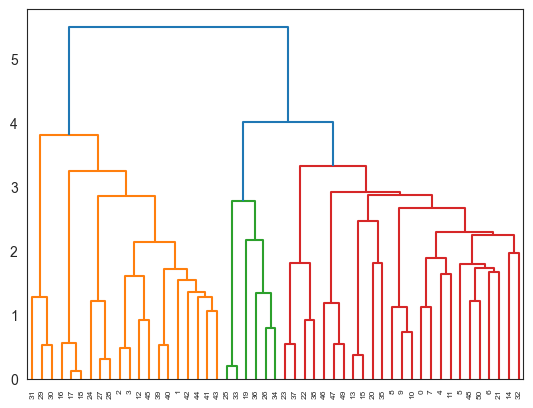

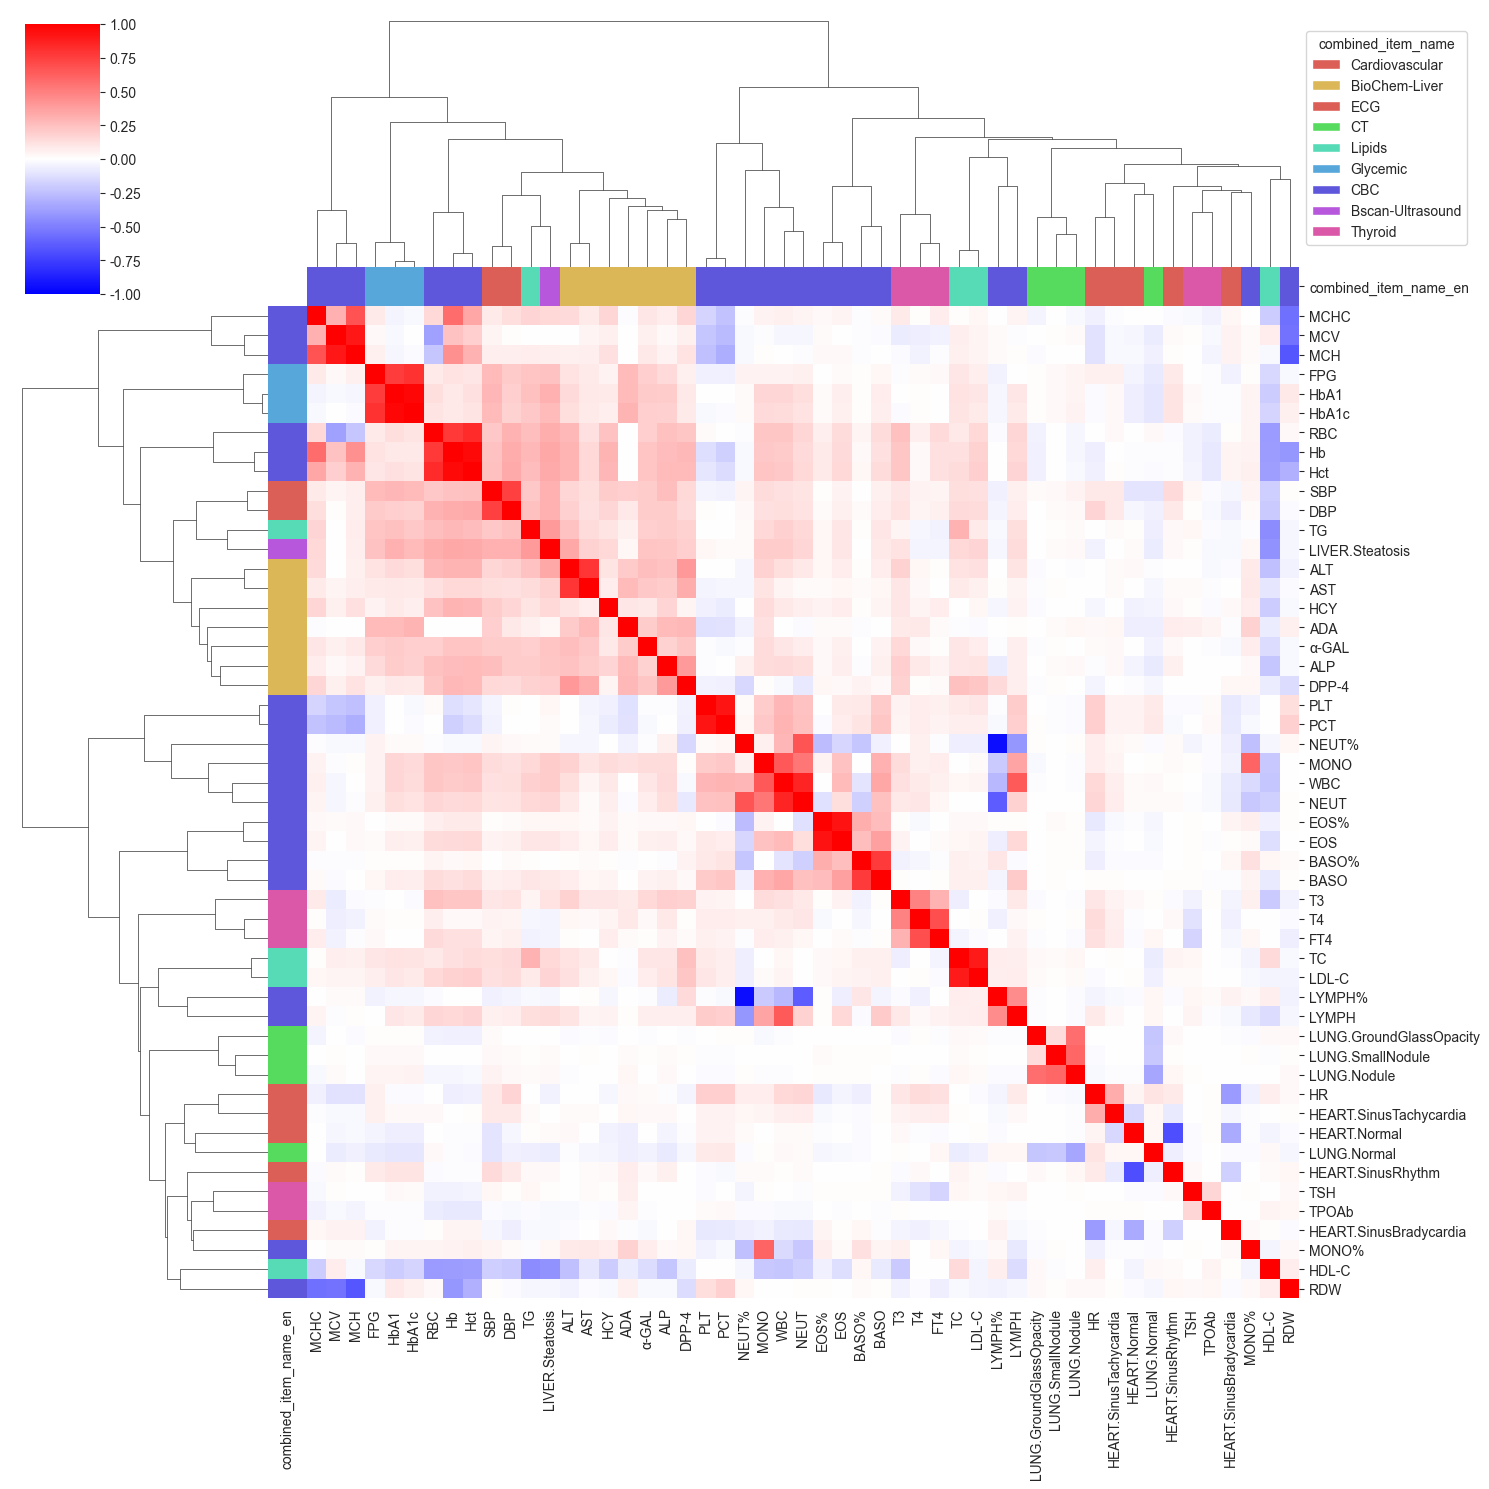

In [10]:
from matplotlib.patches import Patch

ss = sns.color_palette("hls", len(df_meta_groups["combined_item_name_en"].unique()))
lut = dict(zip(df_meta_groups["combined_item_name_en"].unique(), ss.as_hex()))
lut['Cardiovascular']   = '#db5f57'
lut['ECG']   = '#db5f57'

row_colors = df_meta_groups["combined_item_name_en"].map(lut)
row_colors.index = df_meta_groups["item_name_en"]
l_high_lighted = list(df_meta_groups["item_id"])


df_mat = df_table1plus_allmonths[l_high_lighted]
l_high_lighted_names = list(df_meta_groups["item_name_en"])
df_mat.columns = l_high_lighted_names
df_corr = df_mat.corr(method="pearson").fillna(0)
hclust = scipy.cluster.hierarchy.linkage(df_corr.fillna(0), method='ward', metric='euclidean', optimal_ordering=False)
dn = scipy.cluster.hierarchy.dendrogram(hclust)
fig = sns.clustermap(df_corr.fillna(0), cmap="bwr", vmin=-1, vmax=1, method="ward", row_linkage=hclust,
                        row_colors=row_colors, col_colors=row_colors,figsize=(15,15))

fig.ax_heatmap.set_title("")

handles = [Patch(facecolor=lut[name]) for name in lut]
fig.ax_col_dendrogram.legend(handles, lut, title='combined_item_name',
           bbox_to_anchor=(1, 0.5),  loc='center left')
fig.savefig(f"{workdir}/Figure1_F.pdf")

In [11]:
l_high_lighted2 = list(df_meta_groups["item_id"])[0:1] +\
    list(df_meta_groups["item_id"])[2:43] +\
    list(df_meta_groups["item_id"])[1:2] +\
    list(df_meta_groups["item_id"])[43:]



df_mat = df_table1plus_allmonths[l_high_lighted2]
l_high_lighted_names = [ parse_dict_with_default(x, default_dict=rename_dict) for x in l_high_lighted2 ]
df_mat.columns = l_high_lighted_names

df_mat1 = (~pd.isna(df_mat))
df_mat1["year-month"] = df_table1plus_allmonths.apply(lambda x: "%04d-%02d" % (x["year"],x["month"]), axis=1)

df_cnt_melt = pd.melt(
            df_mat1, id_vars=["year-month"]
        )

group_dict = {k:v for k,v in zip(df_meta_groups["item_name_en"], df_meta_groups["combined_item_name_en"])}
df_cnt_melt["group_name"] = [ parse_dict_with_default(x, group_dict) for x in list(df_cnt_melt["variable"]) ]

df_cnt = df_cnt_melt.pivot_table(
            index=["variable", "group_name"], columns="year-month", aggfunc=sum, values="value"
        ).loc[l_high_lighted_names]

df_cnt

,year-month,2020-11,2020-12,2021-01,2021-02,2021-03,2021-04,2021-05,2021-06,2021-07,2021-08,...,2022-09,2022-10,2022-11,2022-12,2023-01,2023-02,2023-03,2023-04,2023-05,2023-06
variable,group_name,,,,,,,,,,,,,,,,,,,,,
HR,Cardiovascular,8682,6086,5309,3233,4621,6307,6746,7600,7010,7836,...,10051,9098,9684,3520,2302,5772,5819,7712,8518,8123
SBP,Cardiovascular,8682,6086,5309,3233,4621,6307,6746,7600,7010,7837,...,10051,9098,9684,3521,2302,5770,5818,7712,8517,8123
DBP,Cardiovascular,8682,6086,5309,3233,4621,6307,6746,7600,7010,7837,...,10051,9098,9684,3521,2302,5772,5819,7712,8518,8123
HEART.Normal,ECG,7086,4751,4898,2744,3740,5032,5759,6721,6010,6416,...,8030,7372,7678,3283,2149,5123,4604,5919,7026,6566
HEART.SinusRhythm,ECG,7086,4751,4898,2744,3740,5032,5759,6721,6010,6416,...,8030,7372,7678,3283,2149,5123,4604,5919,7026,6566
HEART.SinusBradycardia,ECG,7086,4751,4898,2744,3740,5032,5759,6721,6010,6416,...,8030,7372,7678,3283,2149,5123,4604,5919,7026,6566
HEART.SinusTachycardia,ECG,7086,4751,4898,2744,3740,5032,5759,6721,6010,6416,...,8030,7372,7678,3283,2149,5123,4604,5919,7026,6566
LUNG.GroundGlassOpacity,CT,4946,4577,2594,1493,2414,4153,4266,4181,4298,5339,...,5656,5205,5632,2321,1381,2885,3983,4665,4623,4591
LUNG.SmallNodule,CT,4946,4577,2594,1493,2414,4153,4266,4181,4298,5339,...,5656,5205,5632,2321,1381,2885,3983,4665,4623,4591


## Number of features availuable

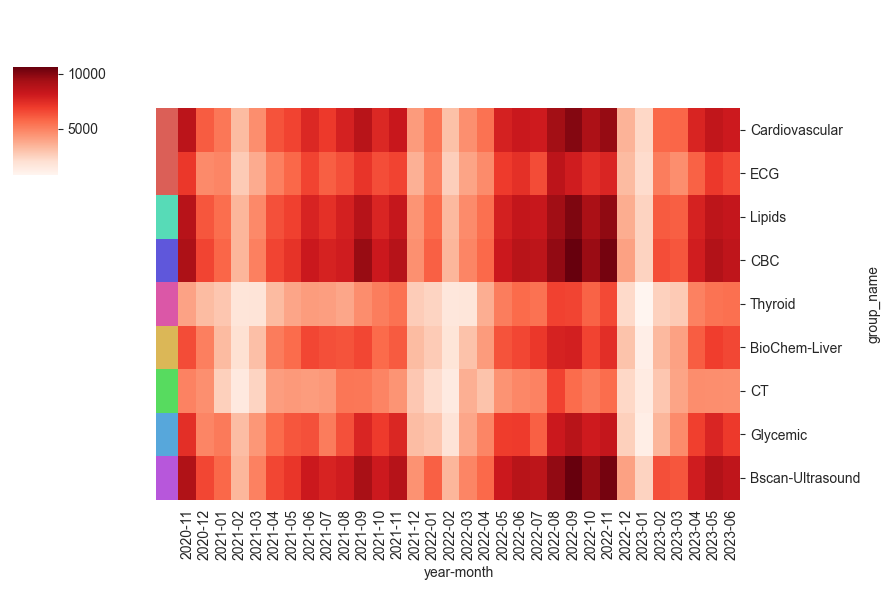

In [12]:
l_groups = [
        'Cardiovascular', 'ECG', 'Lipids',
        'CBC', 'Thyroid', 'BioChem-Liver',
        'CT', 'Glycemic', 'Bscan-Ultrasound',
]
df_cnt_mat = df_cnt.reset_index().groupby("group_name").agg(np.mean).loc[
    l_groups
]

fig = sns.clustermap(
            df_cnt_mat,
            cmap="Reds",
            row_cluster=False,
            row_colors=[ lut[x] for x in l_groups ],
            cbar_pos=(0.02, 0.7, 0.05, 0.18),
            col_cluster=False, figsize=(9,6),
)
fig.savefig(f"{workdir}/Figure1_E.pdf")

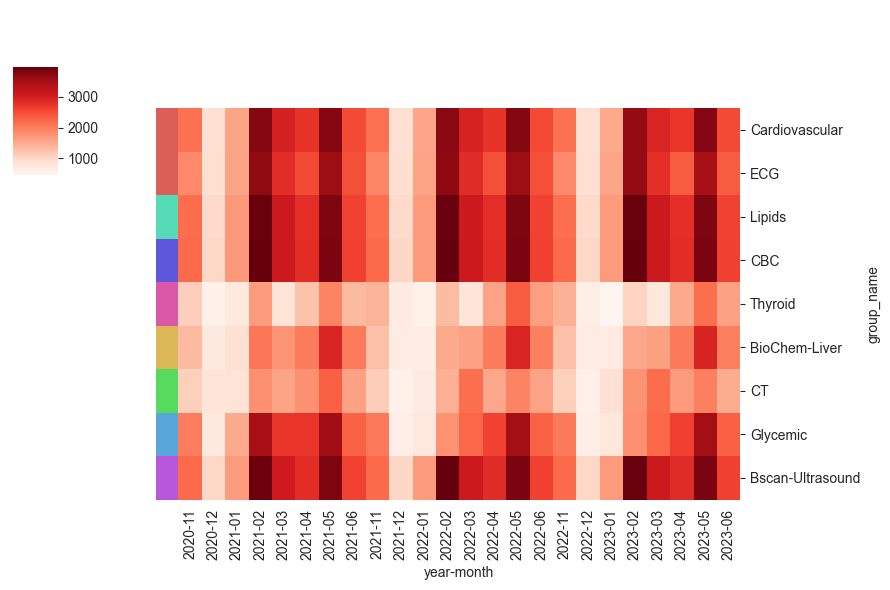

In [13]:
df_mat = df_table1plus_3p_revMM[l_high_lighted2]
l_high_lighted_names = [ parse_dict_with_default(x, default_dict=rename_dict) for x in l_high_lighted2 ]
df_mat.columns = l_high_lighted_names
df_mat1 = (~pd.isna(df_mat))
df_mat1["year-month"] = df_table1plus_3p_revMM.apply(lambda x: "%04d-%02d" % (x["year"],x["month"]), axis=1)

df_cnt_melt = pd.melt(
            df_mat1, id_vars=["year-month"]
        )
df_cnt_melt["group_name"] = [ parse_dict_with_default(x, group_dict) for x in list(df_cnt_melt["variable"]) ]
df_cnt = df_cnt_melt.pivot_table(
            index=["variable", "group_name"], columns="year-month", aggfunc=sum, values="value"
).loc[l_high_lighted_names]

df_cnt_mat = df_cnt.reset_index().groupby("group_name").agg(np.mean).loc[
    l_groups
]
fig = sns.clustermap(
            df_cnt_mat,
            cmap="Reds",
            row_cluster=False,
            row_colors=[ lut[x] for x in l_groups ],
            cbar_pos=(0.02, 0.7, 0.05, 0.18),
            col_cluster=False, figsize=(9,6),
)
fig.savefig(f"{workdir}/FigureS1_B.pdf")

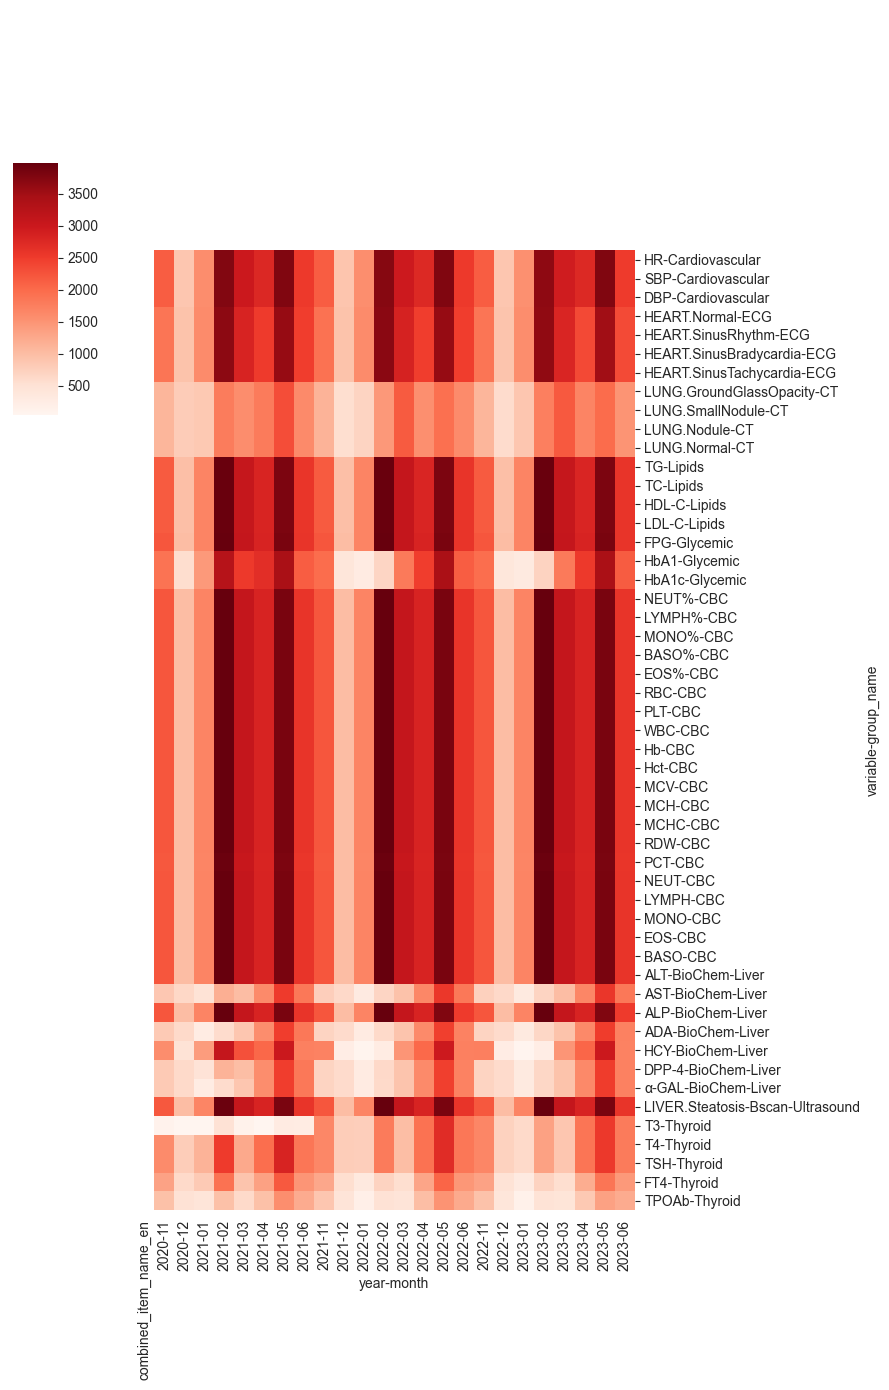

In [14]:
fig = sns.clustermap(df_cnt,
                    cmap="Reds",
                    row_cluster=False,
                    row_colors=row_colors,
                    cbar_pos=(0.02, 0.7, 0.05, 0.18),
                    col_cluster=False, figsize=(9,14),
)
fig.savefig(f"{workdir}/FigureS1_C.pdf")

## Interval of days for 3-periods examination people

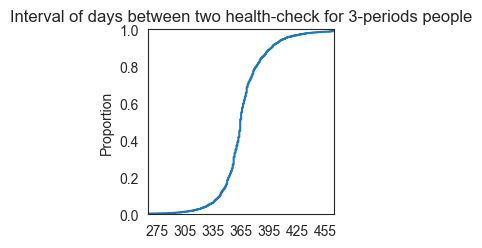

In [15]:
start_date0 = pd.Timestamp('2020-11-01')
df_months = df_table1plus[df_table1plus["sample_id"].isin(l_consecute_man3p)][["sample_id", "period"]]
df_months["ndays"] = df_table1plus[df_table1plus["sample_id"].isin(l_consecute_man3p)].apply(
                            lambda x: pd.Timestamp("%04d-%02d-%02d" % (x["year"],x["month"],x["day"]))-start_date0, axis=1
)
df_months_pvt = df_months.pivot_table(index="sample_id", columns="period", values="ndays", aggfunc=np.nanmedian)
df_months = (df_months_pvt["Test-2023"] - df_months_pvt["Control-2022"]).append(
    (df_months_pvt["Control-2022"] - df_months_pvt["Control-2021"])
) / np.timedelta64(1, 'D')
# ) / np.timedelta64(1, 'M') - 12
fig = plt.figure(figsize=(2.4,2.4))
ax = fig.add_subplot(1,1,1)
sns.ecdfplot(df_months, ax=ax)
ax.set_xlim(-100+365,100+365)
ax.set_xticks([365-90, 365-60, 365-30, 365, 365+30, 365+60, 365+90])
ax.set_title("Interval of days between two health-check for 3-periods people")
fig.savefig(f"{workdir}/Figure1_D.pdf")

## Scatter plot by month for important features

100%|##########| 11/11 [00:00<00:00, 13.38it/s]


len                                                  mean  \
month            1     2     3     4     5     6    11    12           1   
period                                                                     
Control-2021  1698  3969  3078  2836  3827  2604  2215  1009    5.937135   
Control-2022  1695  3976  3078  2834  3830  2608  2214  1008    6.036012   
Test-2023     1696  3969  3075  2834  3829  2607  2212  1008    6.072067   
Control-2021  1685  3930  3054  2819  3794  2576  2198  1004   10.819585   
Control-2022  1679  3945  3054  2819  3814  2594  2199  1005   10.791483   
Test-2023     1681  3940  3054  2820  3815  2592  2202  1005   10.521356   
Control-2021  1698  3969  3078  2836  3827  2604  2215  1009   12.632332   
Control-2022  1695  3976  3078  2834  3830  2608  2214  1008   12.630855   
Test-2023     1696  3968  3075  2834  3829  2607  2212  1008   12.939947   
Control-2021  1698  3969  3078  2834  3825  2602  2215  1009  246.142815   
Control-2022  1695  3976  3078  2834  3830  2607  2213  1008  249.390265   
Test-2023     1695  3968  3074  2832  3827  2606  2212  1008  254.106785   
Control-2021  1698  3969  3078  2836  3827  2604  2215  1009  137.992049   
Control-2022  1695  3976  3078  2834  3830  2608  2214  1008  137.713569   
Test-2023     1696  3969  3075  2834  3829  2607  2212  1008  135.375295   
Control-2021  1591  3755  2990  2767  3766  2519  2142   890   85.405091   
Control-2022  1579  3719  2968  2762  3771  2521  2140   893   84.659911   
Test-2023     1536  3657  2936  2753  3762  2510  2138   876   86.461589   
Control-2021  1591  3755  2990  2767  3766  2519  2142   890  119.526398   
Control-2022  1579  3719  2968  2762  3771  2521  2140   893  119.444585   
Test-2023     1536  3655  2935  2753  3762  2510  2138   877  121.637044   
Control-2021  1591  3755  2990  2767  3766  2519  2142   890   71.133250   
Control-2022  1579  3719  2968  2762  3771  2521  2140   893   71.420519   
Test-2023     1536  3657  2936  2753  3762  2510  2138   877   73.757812   
Control-2021   837  1911   912  1350  2183  1486  1321   629   13.364194   
Control-2022   331   716   562  1292  2058  1469  1271   559   13.374683   
Test-2023      297   707   553  1199  1873  1437  1330   489   13.655387   
Control-2021  1123  2504  1255  1963  2834  1869  1600   783  100.277818   
Control-2022   781  1807   988  1917  2714  1846  1653   790   99.070922   
Test-2023      621  1350   881  1888  2542  1809  1673   725  102.576771   
Control-2021  1697  3972  3078  2836  3828  2604  2215  1009   17.377431   
Control-2022  1696  3976  3078  2835  3831  2608  2214  1008   18.448998   
Test-2023     1695  3973  3078  2834  3830  2607  2212  1008   20.439233   

                          ...    func_q5   func_q95                          \
month                  2  ...         12          1           2           3   
period                    ...                                                 
Control-2021    6.022157  ...   2.900000    3.30000    3.200000    3.400000   
Control-2022    6.097900  ...   2.856015    3.20186    3.257625    3.342315   
Test-2023       6.202184  ...   2.421330    3.30000    3.426960    3.350000   
Control-2021   10.777506  ...   8.350750    8.80000    8.816275    8.700000   
Control-2022   10.723308  ...   8.150600    8.89410    8.800000    8.700000   
Test-2023      10.616168  ...   7.750200    8.20000    8.500000    8.200000   
Control-2021   12.655165  ...  10.851200   11.20000   11.200000   11.300000   
Control-2022   12.648089  ...  11.050350   11.30000   11.200000   11.400000   
Test-2023      12.964756  ...  11.000700   11.50000   11.500000   11.500000   
Control-2021  247.471655  ...  73.560000  126.12150  124.392000  125.000000   
Control-2022  251.307973  ...  77.566500  130.18600  126.000000  126.231500   
Test-2023     255.336190  ...  63.587500  128.00000  135.000000  127.000000   
Control-2021  138.934240  ...  83.000000   96.12150  100.000000  100.000000   
Control-2022  

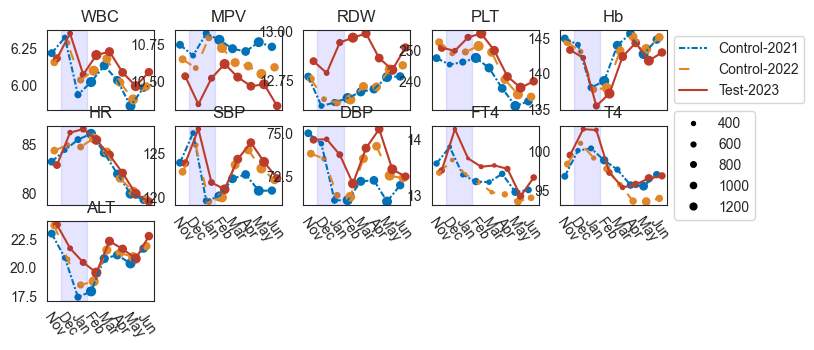

In [16]:
l_tags = [
        'v9045', 'v9065', 'v9063',  'v9064', "v9058", 
        'v000763','v000762', 'v002161', 'v9462', 'v0955',
        'v0017'
]
l_months2 = [11,12,1,2,3,4,5,6]
plt_scatter = Scatter(n_cols=5, figsize=(8,6), n_rows=5, rename_dict=rename_dict)

fig, df_res = plt_scatter.plot_scatter(df_table1plus_3p_revMM, l_tags, order=l_months2)
# fig.savefig("../analysis/liuzhong/human/clinical/figures/Figure1C-scatter.pdf")
fig.savefig(f"{workdir}/Figure1_G.pdf")
df_res